# Reconstruction parcimonieuse ou compressive sensing

## I. Cadre général et première tentative.

Le but du TP est de montrer que des techniques d'optimisation pour le Machine Learning permettent de récupérer des signaux qui admettent dans une certaine base une représentation parcimonieuse, c'est à dire mettant en jeu un faible nombre de coefficients. 

On s'intéresse donc à la reconstruction d'un vecteur $x$ (ici une image codées en niveaux de gris) en utilisant les valeurs de combinaisons aléatoire de certains pixels. Les combinaisons sont représentées par une matrice $\Phi$. 

Une première approche consiste à résoudre le problème $$ \min_x \frac{1}{2} ||\Phi x-y||_2^2$$ pour retrouver l'image.

**Question 1 :** Commenter et compléter le code constituant le reste de la section I.


┌ Warning: `convert(Array{Gray{Any}}, img)` will soon switch to returning an array with non-concrete element type, which adds flexibility but
│ with great cost to performance. To maintain the current behavior, use `Gray{Any}.(img)` instead.
└ @ ImageCore /Users/julienblanchon/.julia/packages/ImageCore/iXG0W/src/deprecations.jl:6
┌ Info: It is recommended that you fix this now to avoid breakage when a new version is released and this warning is removed.
│ Tip: to see all deprecation warnings together with code locations, launch Julia with `--depwarn=yes` and rerun your code.
└ @ ImageCore /Users/julienblanchon/.julia/packages/ImageCore/iXG0W/src/deprecations.jl:7


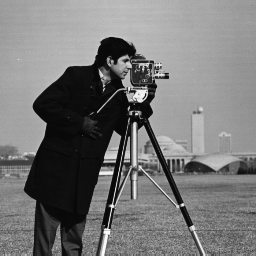

In [1]:
#
# Installation des librairies
#
#Pkg.add("")
#
#

#
# Repertoire ou se trouve le fichier cameraman.tif
#
#cd("$(homedir())/")

#
# Chargement des librairies de traitement d'image
#
using Images, Colors, LinearAlgebra, FFTW


img1 = load("cameraman.tif");    #
img = convert(Array{Gray},img1);   #
A = float(convert(Array,img));   #

tmp = @view img1[:,:]

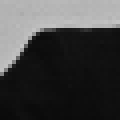

In [2]:
# Extraction d'une sous-image contrastée
k    = 30;
orig = 60;
Aloc = A[orig:orig+k-1,orig:orig+k-1];
x   = (Aloc[:]);
n   = length(x);
m   = 500; 
Phi = randn(m,n);

imhsv=colorview(Gray,float(Aloc));
tmp=@view imhsv[:,:]

#
# Fin Extraction
#


**Question 2 :** Résoudre le problème de moindres carrés $$\min_x || \Phi x -y ||_2,$$ et afficher le résultat (attention, l'image doit être en niveaux de gris). Que constate-t-on?

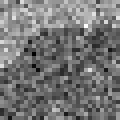

In [3]:
y = Phi * x; # Vecteur des "observations" de l'image
## A compléter
# |\phi * x - y|
#x_best = (transpose(Phi) * Phi) \ (transpose(Phi) * y) 
x_best = pinv(Phi) * y
x_best = (x_best .- minimum(x_best)) ./ (maximum(x_best) - minimum(x_best))
x_reconstruct = reshape(x_best, (k, k))

colorview(Gray, x_reconstruct)
## Fin à compléter

#### II. Compressive sensing


On désire utiliser à présent la transformation discrète en cosinus pour obtenir une représentaiton parcimonieuse d'une image. Cette transfomation bijective est obtenue avec la fonction `dct`, son inverse s'appelant `idct`.

A partir de la fonction IDCT de Julia, on calcule la matrice  $\Theta = \Phi*\Psi$, avec $\Psi$ la matrice représentative de IDCT dans la base canonique.


In [4]:
Theta = zeros(m,n);
for ii = 1:n
    ii
    ek = zeros(1,n);
    ek[ii] = 1; #Vecteur ei de la base canonique
    psi = idct(ek)';
    Theta[:,ii] = Phi*psi;
end

### II.1. Utilisation d'un algorithme de sous-gradient

**Qestion 3 :** Soit $\lambda > 0$ (ici $\lambda=100$). Expliquer l'intérêt de 
 calculer $x_{sg}= \Psi z$ où $z$ résout $$\min_z \frac{1}{2} ||\Phi  \cdot \Psi  \cdot z -y||_2^2+ \lambda ||z||_1.$$ 
 
**Qestion 4 :** Justifier la convexité de la fonctionnelle et donner son sous-différentiel.

**Qestion 5 :** Compléter ci-dessous le code de sous-gradient. Vous considèrerez les différents choix de pas $\alpha_i$ vus en cours, et trouverez des réglages permettant d'obtenir un bon rendu visuel. On pourra se rappeler du fait que la solution de norme minimale a une norme inférieure à dix.


In [16]:
z = zeros(k^2, 1);
i = 0;
lambda = 1e-2;
choix_pas = 3; # 1 cas a, 2 cas b, 3 cas c
while i <= 1000
    i = i + 1
    ## A compléter
    # Calcul du sous gradients
    grad_k = 0.5 * transpose(Theta) * (Theta * z - y) + lambda * sign.(z)
    
    if choix_pas == 1
        z -= 1e-5 * grad_k #Constant
    elseif choix_pas == 2
        z -= 1 / (100*i) * grad_k #S1 diverge et S2 converge
    elseif choix_pas == 3
        z -= 1 / (1000*sqrt(i)) * grad_k #S1 diverge et S2 diverge
    end
    ## fin à compléter
end
norm(Theta \ y)

8.796921223843954

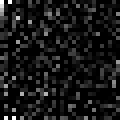

In [17]:
z_reshape = reshape(z, (k, k))

colorview(Gray, z_reshape)

**Question 6 :** Expliquer le code suivant et conclure sur l'utilisation du sous-gradient

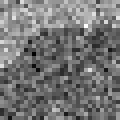

In [18]:
function my_function(n,k,z)
    x2 = zeros(n,1);
    for ii = 1:n
        ii
        ek = zeros(1,n);
        ek[ii] = 1;
        psi = idct(ek)';
        x2 = x2+psi*z[ii];
    end
    x2 = reshape(x2,(k,k));
    x2 = 1/(maximum(x2).-minimum(x2))*(x2.-minimum(x2));
    return x2
end
#
x2 = my_function(n,k,z);
imhsv = colorview(Gray, float(x2));
tmp=@view imhsv[:,:]

# II.2. Utilisation d'un algorithme de sous-gradient projeté


**Question 7 :**  Expliquer l'intérêt de 
 calculer $x_{sgp}= \Psi z$ où $z$ résout $$\min_{\Phi  \cdot \Psi  \cdot z =y}  ||z||_1.$$

**Question 8 :** Rappeler la formule de la projection sur le convexe $\{x, \Phi  \cdot \Psi  \cdot z =y \}$ vue en cours.

**Question 9 :** Résoudre ce problème par l'algorithme de sous-gradient projeté et finaliser le calcul de la solution.

In [23]:
z = zeros(k^2, 1);
i = 3;
choix_pas = 1; # 1 cas a, 2 cas b, 3 cas c

##Initialisation (possible)
## A compléter
pinvTheta = pinv(Theta)
function projection(z)
    return z - pinvTheta * (Theta * z - y)
end
## Fin à compléter

while i <= 1000
    i = i + 1
    ## A compléter
    grad_k = sign.(z)
    if choix_pas == 1
        z -= 1e-5 * grad_k #Constant
    elseif choix_pas == 2
        z -= 1 / (100*i) * grad_k #S1 diverge et S2 converge
    elseif choix_pas == 3
        z -= 1 / (1000*sqrt(i)) * grad_k #S1 diverge et S2 diverge
    end
    z = projection(z)
    ## Fin à compléter
end

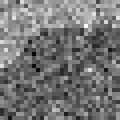

In [24]:
x3 = my_function(n,k,z);
imhsv = colorview(Gray,float(x3));
tmp =@view imhsv[:,:]